In [ ]:
# Import necessary libraries for data visualization and analysis

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.statespace import exponential_smoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta


Mounted at /content/gdrive/


In [ ]:
# Set up charting formats

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [14.0, 5.0]
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')


In [ ]:
# Load data from CSV file

data = pd.read_csv('./data/MELIPRMSA19100.csv', index_col=0, parse_dates=True)
data.index.freq = 'MS'


In [ ]:
# Rename columns and prepare for plotting

data.index.name = "Months"
data.rename(columns={"MELIPRMSA19100": "Median Housing Price"}, inplace=True)


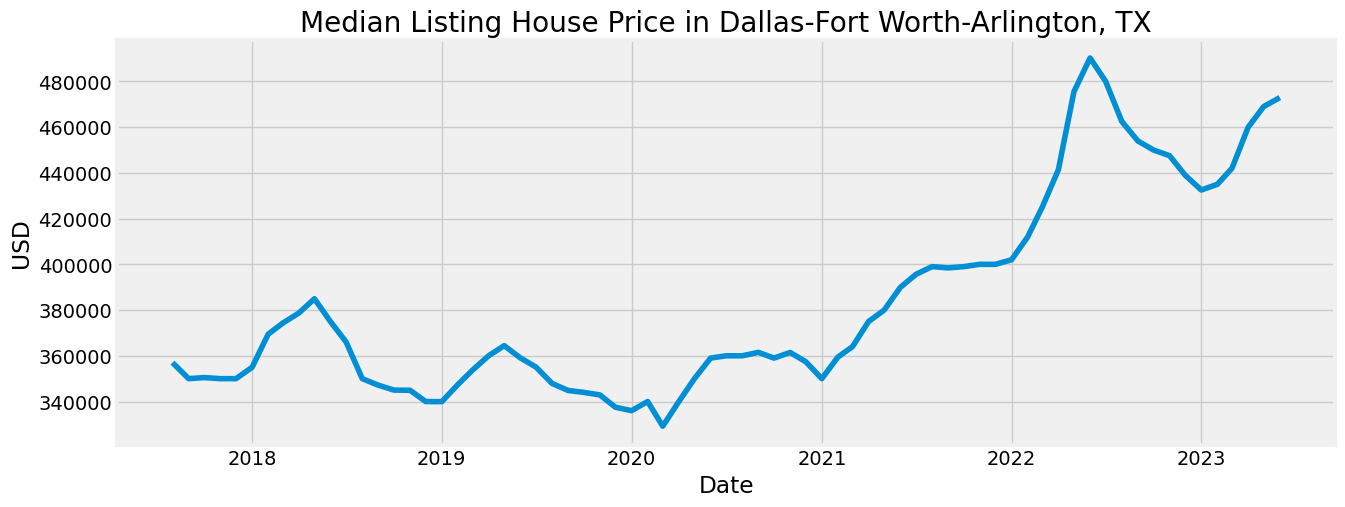

In [ ]:
# Plot the data

plt.figure(facecolor='white')
plt.plot(data.index, data['Median Housing Price'])
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Median Listing House Price in Dallas-Fort Worth-Arlington, TX')
plt.grid(True)
plt.show()


In [ ]:
# Split data into training and testing sets

y = data['Median Housing Price']
train_size = int(len(y) * 0.75)
y_train = y[0:train_size]
y_test = y[train_size:]


In [ ]:
# Apply Exponential Smoothing (ETS) model

model_ETS = ExponentialSmoothing(y_train, trend='additive', damped_trend=True, seasonal='additive', initialization_method="estimated")
fit_model_ETS = model_ETS.fit()
fcast_ETS = fit_model_ETS.forecast(steps=len(y_test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


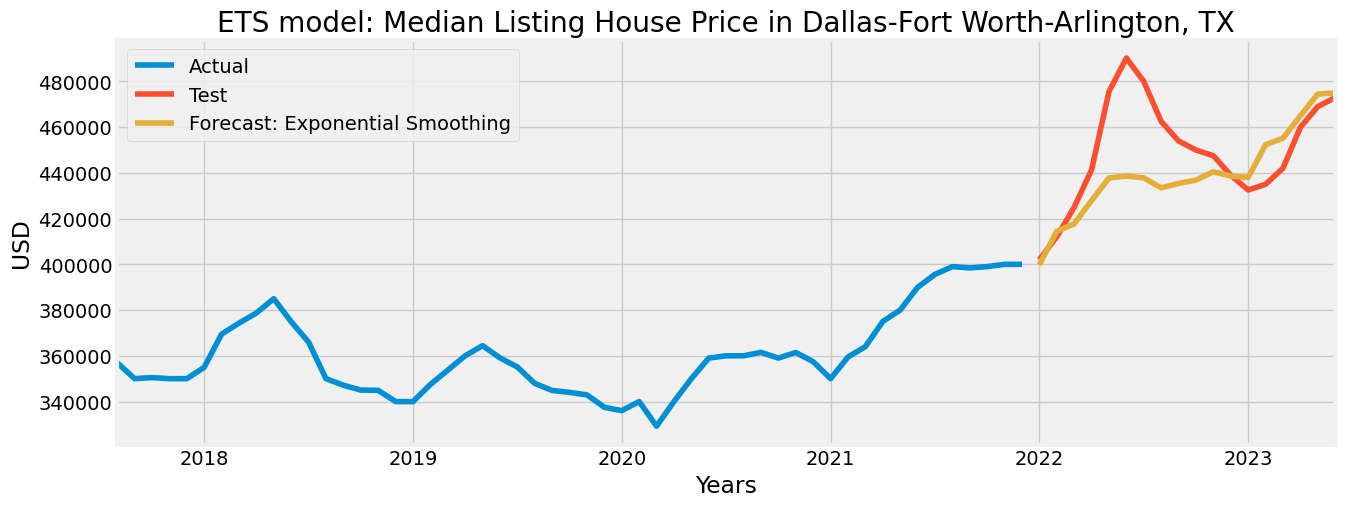

In [ ]:
# Plot ETS model results

plt.figure(facecolor='white')
y_train.plot(label='Actual')
y_test.plot(label="Test")
fcast_ETS.plot(label='Forecast: Exponential Smoothing')
plt.legend()
plt.xlabel('Years')
plt.ylabel('USD')
plt.title('ETS model: Median Listing House Price in Dallas-Fort Worth-Arlington, TX')
plt.show()


In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 21.2 MB/s eta 0:00:00


In [ ]:
# Calculate and display accuracy metrics for ETS model

def accuracy(y_test, y_pred):
    # Import necessary functions for evaluation
    from statsmodels.tools.eval_measures import rmse, rmspe, meanabs, mse
    from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
    RMSE = rmse(y_test, y_pred)
    RMSPE = rmspe(y_test, y_pred)
    MAE = meanabs(y_test, y_pred)
    MSE = mse(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    print('Error Statistics : RMSE %f' % RMSE, ' RMSPE %f' % RMSPE, ' MAE %f' % MAE, ' MSE %f' % MSE , ' MAPE %f' % MAPE)

accuracy(y_test, fcast_ETS)


Error Statistics : RMSE 21199.458009  RMSPE 0.447434  MAE 15205.498550  MSE 449417019.857800  MAPE 0.032804


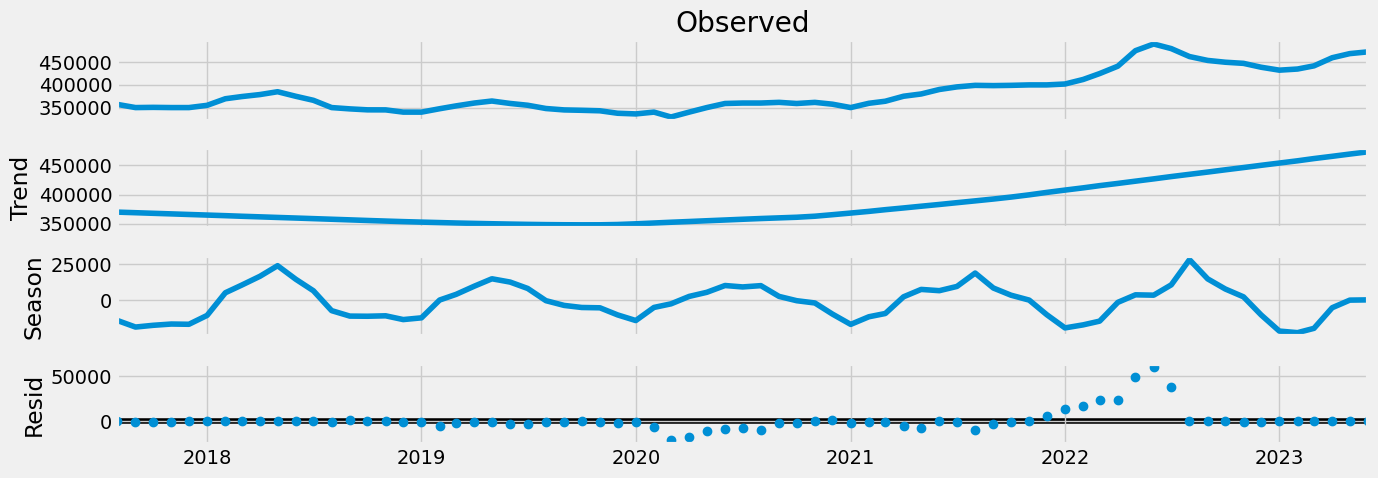

In [ ]:
# Apply Seasonal-Trend decomposition using LOESS (STL) model

model = STL(data, robust=True)
fit = model.fit()
fit.plot()
plt.show()


In [ ]:
# Apply STLForecast model based on Exponential Smoothing (ES)

ES = exponential_smoothing.ExponentialSmoothing
config = {"trend": True}

stlf_es = STLForecast(y_train, ES, model_kwargs=config)
fit_es = stlf_es.fit()
fcast_es = fit_es.forecast(steps=len(y_test))


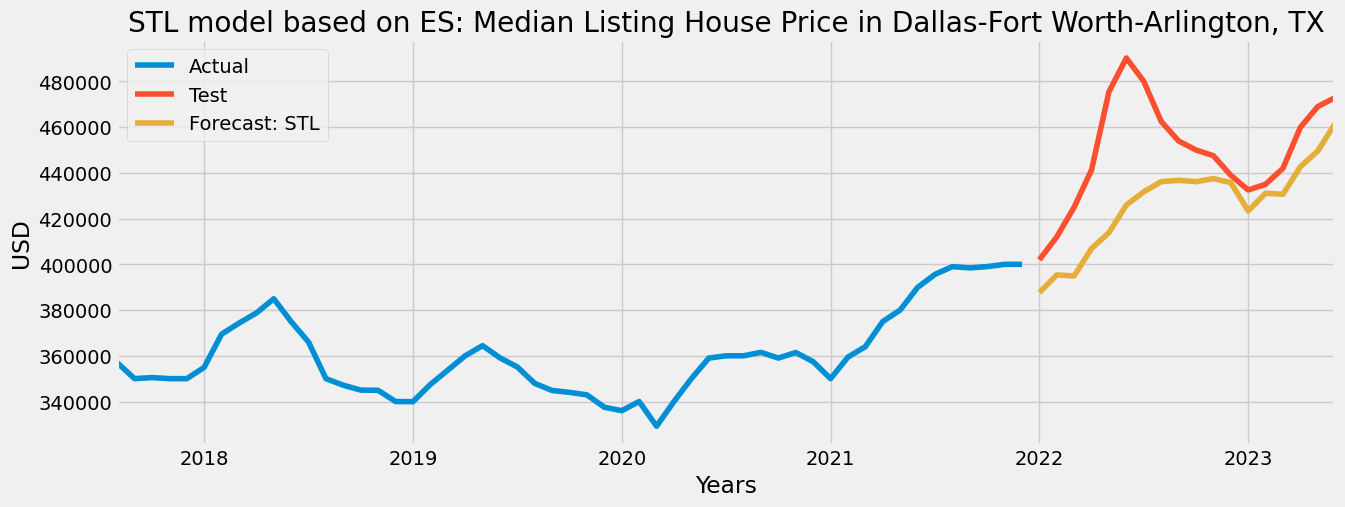

In [ ]:
# Plot STLForecast results

y_train.plot(label='Actual')
y_test.plot(label="Test")
fcast_es.plot(label='Forecast: STL')
plt.title('STL model based on ES: Median Listing House Price in Dallas-Fort Worth-Arlington, TX')
plt.xlabel('Years')
plt.ylabel('USD')
plt.legend()
plt.show()


In [ ]:
# Calculate and display accuracy metrics for STLForecast model

accuracy(y_test, fcast_es)


Error Statistics : RMSE 29019.395223  RMSPE 0.619919  MAE 22926.133097  MSE 842125299.121310  MAPE 0.050005


In [ ]:
# Install the necessary library for ARIMA model

!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


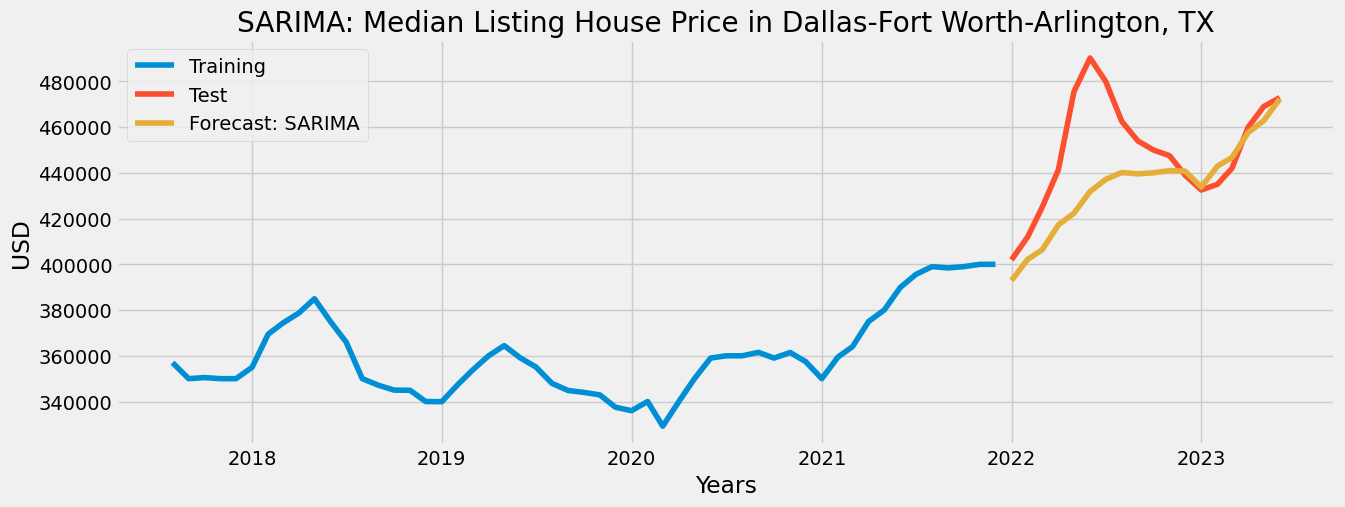

In [ ]:
# Apply SARIMA model

model = SARIMAX(y_train, order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
results = model.fit()
# Plot SARIMA results

forecast_object = results.get_forecast(steps=len(y_test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

plt.plot(y_train.index, y_train, label='Training')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(dates, mean, label='Forecast: SARIMA')
plt.title('SARIMA: Median Listing House Price in Dallas-Fort Worth-Arlington, TX')
plt.xlabel('Years')
plt.ylabel('USD')
plt.legend()
plt.show()


In [ ]:
# Calculate and display accuracy metrics for SARIMA model

accuracy(y_test, mean)


Error Statistics : RMSE 23762.129333  RMSPE 0.502010  MAE 16338.386677  MSE 564638790.446558  MAPE 0.035402


In [ ]:
# Prepare for forecasting into the future

start_date = datetime(year=2023, month=7, day=1)
horizon = pd.date_range(start=start_date, periods=24, freq="MS")


In [ ]:
# Generate predictions with confidence intervals

pred_table = results.get_prediction(start=len(data), end=len(data)+24, dynamic=False)
mean = pred_table.predicted_mean
pred_intervals = pred_table.conf_int(0.05)
lower = pred_intervals.iloc[:, 0]
upper = pred_intervals.iloc[:, 1]


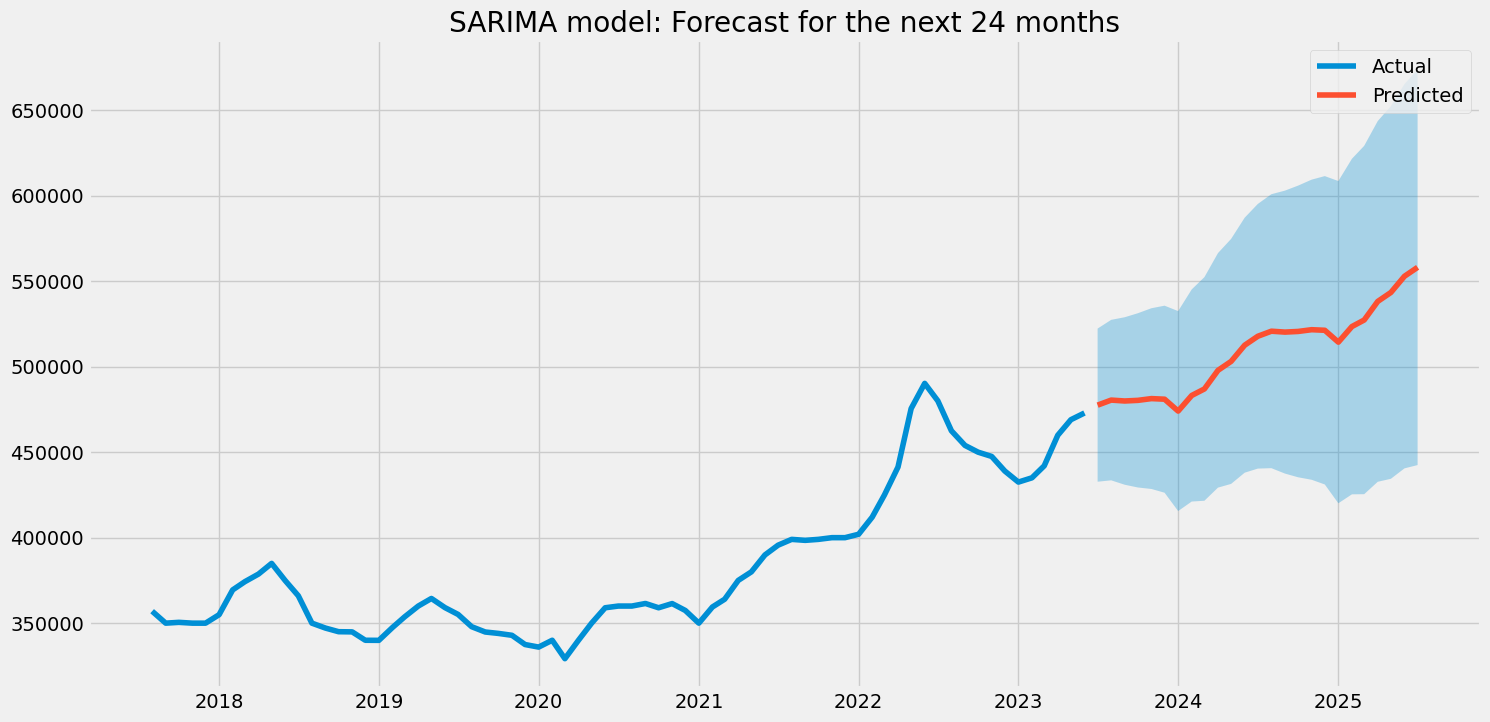

In [ ]:
# Plot predictions with confidence intervals

plt.figure(figsize=(16, 8))
plt.plot(data.index, data["Median Housing Price"], label='Actual')
plt.plot(mean.index, mean, label='Predicted')
plt.fill_between(mean.index, lower, upper, alpha=0.3)
plt.title('SARIMA model: Forecast for the next 24 months')
plt.legend()
plt.show()
